In [16]:
import io
import re
import string
import tqdm
import os
import numpy as np
import string
from nltk.corpus import stopwords
from nltk import Text

from music21 import *

np.random.seed(42)

In [2]:
def transpose_notes(notes):
    midi_stream = stream.Stream(notes)
    ori_key = midi_stream.analyze('key')
    k_interval = interval.Interval(ori_key.tonic, key.Key('C').tonic)
    new_stream = midi_stream.transpose(k_interval)
    return new_stream

def softmax(vec):
    return np.exp(vec) / np.exp(vec).sum()

In [3]:
file_list = os.listdir(r"./scores/schumann")
mxl_file_list = [file for file in file_list if '.mxl' in file]

schumann_list = []

for mxl_file in mxl_file_list:
    schumann = corpus.parse(f'schumann/{mxl_file}')
    if 'major' in str(schumann.analyze('key')):
        sb = schumann.getElementsByClass('Part')
        for part in sb:
            if 'Violin' in str(part):
                sp_ind = [str(soprano) for soprano in sb].index(str(part))
                sp = sb[sp_ind]
                tn = transpose_notes(sp)
                note_list = [(str(notes.pitches)[22:-3],notes.beat) for notes in tn.recurse().notes if 'music' not in str(notes.pitches)[22:-3]]
                schumann_list.append(note_list)

In [6]:
note_vertex, index = {}, 0  # start indexing from 1
for i in range(len(schumann_list)):
    for schumann_note in schumann_list[i]:
        if schumann_note not in note_vertex:
            note_vertex[schumann_note] = index
            index += 1
vertex_size = len(note_vertex)
print(note_vertex)

{('B4', 1.25): 0, ('C5', 1.5): 1, ('B4', 1.75): 2, ('B4', 2.0): 3, ('A4', 2.25): 4, ('G4', 2.5): 5, ('F#4', 2.75): 6, ('G4', 1.0): 7, ('A4', 1.5): 8, ('B4', 1.0): 9, ('E5', 1.5): 10, ('C5', 1.75): 11, ('G4', 2.25): 12, ('F#4', 2.5): 13, ('E4', 2.75): 14, ('A4', 1.0): 15, ('G4', 1.5): 16, ('G4', 2.0): 17, ('F#4', 2.25): 18, ('E4', 2.5): 19, ('D#4', 2.75): 20, ('F#4', 1.0): 21, ('E4', 1.5): 22, ('D#4', 2.5): 23, ('E4', 1.0): 24, ('D4', 2.5): 25, ('C4', 1.0): 26, ('C5', 1.25): 27, ('D5', 1.5): 28, ('C5', 2.0): 29, ('B4', 2.25): 30, ('A4', 2.5): 31, ('G4', 2.75): 32, ('F4', 1.0): 33, ('E4', 2.0): 34, ('D4', 1.5): 35, ('D4', 1.0): 36, ('D4', 2.0): 37, ('D4', 2.25): 38, ('B4', 2.5): 39, ('E4', 1.25): 40, ('D#4', 1.0): 41, ('D#4', 2.0): 42, ('E4', 2.875): 43, ('C5', 1.875): 44, ('A4', 2.0): 45, ('B3', 2.875): 46, ('G4', 1.875): 47, ('D#4', 1.5): 48, ('D5', 1.25): 49, ('F5', 1.5): 50, ('E5', 1.75): 51, ('D5', 2.0): 52, ('C5', 2.25): 53, ('A4', 2.75): 54, ('A4', 1.25): 55, ('F#4', 1.75): 56, ('

In [5]:
schumann_list_total = []
for i in range(len(schumann_list)):
    for j in range(len(schumann_list[i])):
        schumann_list_total.append(schumann_list[i][j])
len(schumann_list_total)

1001

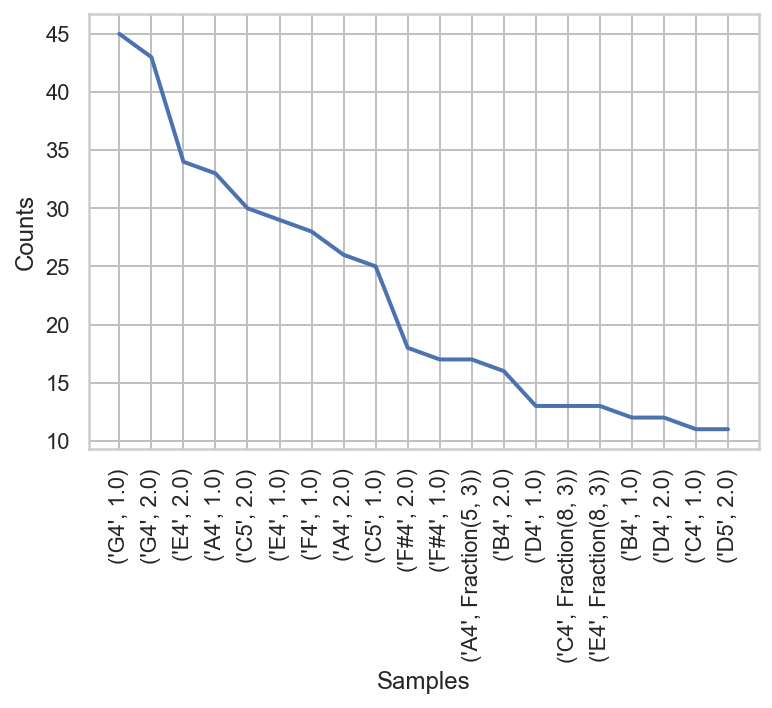

In [7]:
text = Text(schumann_list_total)
text.plot(20)
plt.show()

In [8]:
str_note_vertex = [str(note_v) for note_v in note_vertex]
df = pd.DataFrame(0, index=str_note_vertex, columns=str_note_vertex)
for i in range(len(schumann_list)):
    for j in range(len(schumann_list[i])-1):
        df.loc[str(schumann_list[i][j]),str(schumann_list[i][j+1])] += 1
df = df.sort_index()
df = df.reindex(sorted(df.columns), axis=1)
df

,"('A#4', 1.0)","('A#4', 2.0)","('A#4', Fraction(5, 3))","('A#4', Fraction(7, 3))","('A-3', 1.0)","('A-3', 2.0)","('A-3', Fraction(7, 3))","('A-4', 1.0)","('A-4', 2.0)","('A-4', Fraction(5, 3))","('A-4', Fraction(7, 3))","('A-5', Fraction(8, 3))","('A3', 1.0)","('A3', 2.0)","('A3', Fraction(5, 3))","('A3', Fraction(7, 3))","('A4', 1.0)","('A4', 1.25)","('A4', 1.5)","('A4', 1.75)","('A4', 2.0)","('A4', 2.25)","('A4', 2.5)","('A4', 2.75)","('A4', Fraction(5, 3))","('A4', Fraction(7, 3))","('A4', Fraction(8, 3))","('A5', 1.75)","('A5', Fraction(7, 3))","('B#3', 1.0)","('B#4', 2.0)","('B#4', Fraction(7, 3))","('B--3', 1.0)","('B--3', 2.0)","('B-3', 1.0)","('B-3', 2.0)","('B-3', Fraction(5, 3))","('B-3', Fraction(8, 3))","('B-4', 1.0)","('B-4', 2.0)","('B-4', Fraction(4, 3))","('B-4', Fraction(5, 3))","('B-4', Fraction(7, 3))","('B-4', Fraction(8, 3))","('B-5', 1.0)","('B-5', 2.0)","('B-5', Fraction(5, 3))","('B3', 1.0)","('B3', 2.0)","('B3', 2.875)","('B3', Fraction(5, 3))","('B3', Fraction(8, 3))","('B4', 1.0)","('B4', 1.25)","('B4', 1.75)","('B4', 2.0)","('B4', 2.25)","('B4', 2.5)","('B4', Fraction(4, 3))","('B4', Fraction(5, 3))",...,"('F#3', Fraction(8, 3))","('F#4', 1.0)","('F#4', 1.75)","('F#4', 2.0)","('F#4', 2.25)","('F#4', 2.5)","('F#4', 2.75)","('F#4', Fraction(5, 3))","('F#4', Fraction(7, 3))","('F#4', Fraction(8, 3))","('F#5', 2.0)","('F#5', Fraction(4, 3))","('F#5', Fraction(5, 3))","('F#5', Fraction(8, 3))","('F3', Fraction(8, 3))","('F4', 1.0)","('F4', 1.5)","('F4', 1.875)","('F4', 2.0)","('F4', Fraction(4, 3))","('F4', Fraction(5, 3))","('F4', Fraction(7, 3))","('F4', Fraction(8, 3))","('F5', 1.0)","('F5', 1.25)","('F5', 1.5)","('F5', 2.0)","('F5', Fraction(5, 3))","('F5', Fraction(8, 3))","('G#3', Fraction(7, 3))","('G#4', 1.0)","('G#4', 2.0)","('G#4', Fraction(4, 3))","('G#4', Fraction(5, 3))","('G#4', Fraction(7, 3))","('G#4', Fraction(8, 3))","('G-4', 1.0)","('G-4', Fraction(5, 3))","('G-5', 1.0)","('G-5', Fraction(5, 3))","('G-5', Fraction(8, 3))","('G3', 1.0)","('G3', Fraction(7, 3))","('G3', Fraction(8, 3))","('G4', 1.0)","('G4', 1.5)","('G4', 1.875)","('G4', 2.0)","('G4', 2.25)","('G4', 2.5)","('G4', 2.75)","('G4', Fraction(4, 3))","('G4', Fraction(5, 3))","('G4', Fraction(7, 3))","('G4', Fraction(8, 3))","('G5', 1.0)","('G5', 2.0)","('G5', Fraction(5, 3))","('G5', Fraction(7, 3))","('G5', Fraction(8, 3))"
"('A#4', 1.0)",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
"('A#4', 2.0)",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0
"('A#4', Fraction(5, 3))",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
"('A#4', Fraction(7, 3))",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
"('A-3', 1.0)",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...

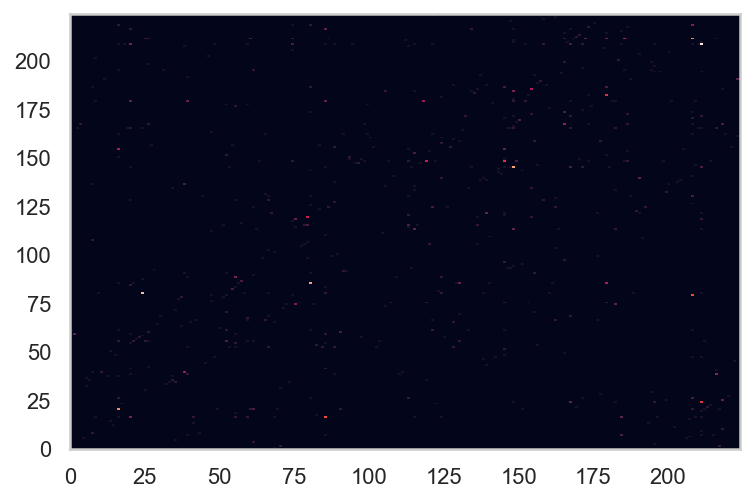

In [9]:
plt.pcolor(df)

In [10]:
class Skipgram:
    X_train = []
    y_train = []
    
    def __init__(self, d, window_size, alpha, epochs):
        self.d = d    # dimension of embedding vector
        self.window_size = window_size    # window_size
        self.alpha = alpha    # learning rate
        self.epochs = epochs
        
    def preprocessing(self, sentences):
        self.words = {}    # 모든 단어 dict
        # sentence : 1개의 곡(선율)
        for sentence in sentences:
            # word : 1개의 음표
            for word in sentence:
                if word not in self.words:
                    self.words[word] = 1
                else:
                    self.words[word] += 1

        self.n = len(self.words)   # n : 모든 단어(음표)의 수
        self.words = sorted(list(self.words.keys()))
        self.word_dict = {word : i for i,word in enumerate(self.words)}

        for sentence in sentences:
            for i in range(len(sentence)):
                # 원핫인코딩
                center_word = np.zeros(self.n)
                center_word[self.word_dict[sentence[i]]] = 1
                context = np.zeros(self.n)
                for j in range(max(0, i-self.window_size), min(len(sentence)-1, i+self.window_size)):
                    context[self.word_dict[sentence[j]]] += 1
                self.X_train.append(center_word)
                self.y_train.append(context)
        
    def feedforward(self, X):
        self.h = np.dot(self.W1.T,X)
        self.u = np.dot(self.W2.T,self.h)
        self.y = softmax(self.u)
        return self.y
    
    def backpropagate(self,x,t):
        error_mat = np.zeros((int(t.sum()), self.n))
        for i, context_note in enumerate(np.where(t)[0]):
            y_true = np.zeros(self.n)
            y_true[context_note] = 1
            error = self.y - y_true
            error_mat[i] = error.T
        dedw2 = np.zeros(self.W2.shape)
        ei = error_mat.sum(axis=0)
        for i in range(self.d):
            for j in range(self.n):
                dedw2[i][j] = ei[j] * self.h[i]
        eh = ei*self.W2
        self.W2 -= self.alpha*dedw2
        self.W1 -= self.alpha*eh.T
        
    def fit(self, sentences):
        self.preprocessing(sentences)
        self.W1 = np.random.uniform(-0.8, 0.8, (self.n, self.d))
        self.W2 = np.random.uniform(-0.8, 0.8, (self.d, self.n))
        self.prevloss = int(1e9)
        for epoch in range(self.epochs):
            self.loss = 0
            for j in range(len(self.X_train)):
                self.feedforward(self.X_train[j])
                self.backpropagate(self.X_train[j],self.y_train[j])
                for m in np.where(self.y_train[j])[0]:
                    self.loss += -1*self.u[m]
                self.loss += int(self.y_train[j].sum())*np.log(np.sum(np.exp(self.u)))
            print("epoch ", epoch+1, " loss = ",self.loss)
            if self.loss > self.prevloss:
                print("Callback executed")
                break
            self.alpha *= 1/(1+self.alpha*epoch)
        
    def predict(self,word,number_of_predictions):
        if word in self.words:
            index = self.word_dict[word]
            X = [0 for i in range(self.n)]
            X[index] = 1
            prediction = self.feedforward(X)
            output = {}
            for i in range(self.n):
                output[prediction[i]] = i

            top_context_words = []
            for k in sorted(output,reverse=True):
                top_context_words.append(self.words[output[k]])
                if(len(top_context_words)>=number_of_predictions):
                    break

            return top_context_words
        else:
            print("Word not found in dictionary")

In [11]:
sg = Skipgram(4, 2, 0.001, 75)
sg.fit(schumann_list)

epoch  1  loss =  16254.390613162446
epoch  2  loss =  16235.705679744427
epoch  3  loss =  16217.288775656494
epoch  4  loss =  16199.081500355756
epoch  5  loss =  16181.027833599528
epoch  6  loss =  16163.07431721125
epoch  7  loss =  16145.17029020799
epoch  8  loss =  16127.268186749056
epoch  9  loss =  16109.323906461552
epoch  10  loss =  16091.297266271487
epoch  11  loss =  16073.15254154324
epoch  12  loss =  16054.859101481483
epoch  13  loss =  16036.392138513822
epoch  14  loss =  16017.73348252659
epoch  15  loss =  15998.87247687174
epoch  16  loss =  15979.806872323858
epoch  17  loss =  15960.543666331183
epoch  18  loss =  15941.099777877635
epoch  19  loss =  15921.502405820092
epoch  20  loss =  15901.788878406542
epoch  21  loss =  15882.005778557043
epoch  22  loss =  15862.207145555392
epoch  23  loss =  15842.451634575069
epoch  24  loss =  15822.79867887109
epoch  25  loss =  15803.303938269672
epoch  26  loss =  15784.01458274591
epoch  27  loss =  15764.965

In [12]:
print(sg.predict(('C4', 1.0),10))

[('E4', 2.0), ('G4', 2.0), ('F#4', 2.0), ('G4', 2.5), ('C5', Fraction(4, 3)), ('F4', Fraction(8, 3)), ('B4', Fraction(8, 3)), ('C#5', 1.0), ('C5', 2.0), ('G5', Fraction(5, 3))]


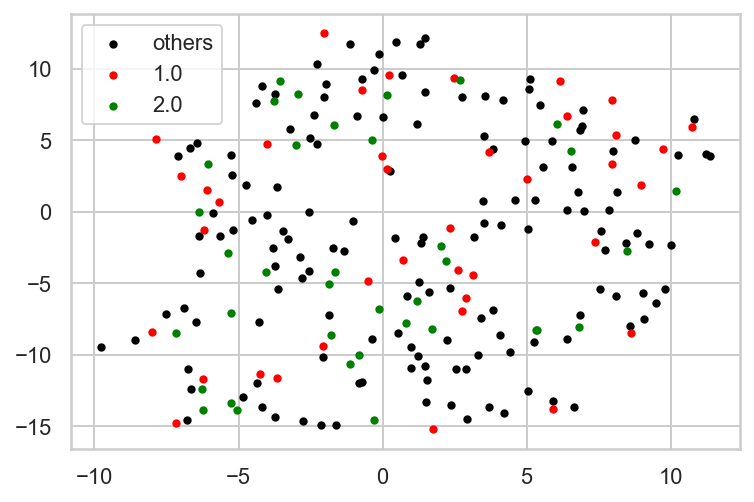

In [38]:
# plot embedded matrix and color points with respect to beat

N = len(df.columns)
beats = ['others','1.0','2.0','3.0','4.0']
labels = np.zeros(N)
for i in range(N):
    if '1.0' in df.columns[i]:
        labels[i] = 1
    if '2.0' in df.columns[i]:
        labels[i] = 2
    if '3.0' in df.columns[i]:
        labels[i] = 3
    if '4.0' in df.columns[i]:
        labels[i] = 4

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

cdict = {0: 'black', 1:'red', 2: 'green', 3:'orange', 4:'blue'}

model = TSNE()
transformed = model.fit_transform(sg.W1)

xs = transformed[:,0]
ys = transformed[:,1]
fig, ax = plt.subplots()
for g in np.unique(labels):
    ix = np.where(labels == g)
    ax.scatter(xs[ix], ys[ix], c = cdict[g], label = beats[int(g)], s = 10)
ax.legend()
plt.show()

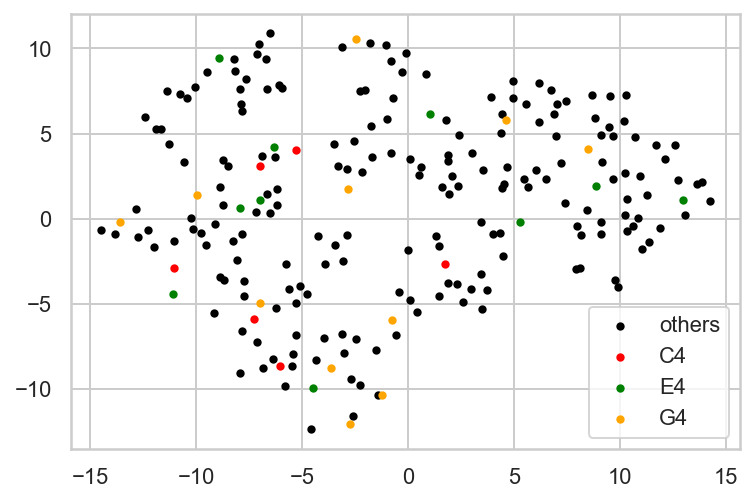

In [37]:
# plot embedded matrix and color points with respect to pitch


labels = np.zeros(N)
tonics = ['others','C4','E4','G4']
for i in range(N):
    if 'C4' in df.columns[i]:
        labels[i] = 1
    if 'E4' in df.columns[i]:
        labels[i] = 2
    if 'G4' in df.columns[i]:
        labels[i] = 3

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

cdict = {0: 'black', 1:'red', 2: 'green', 3:'orange', 4:'blue'}

model = TSNE()
transformed = model.fit_transform(sg.W1)

xs = transformed[:,0]
ys = transformed[:,1]
fig, ax = plt.subplots()
for g in np.unique(labels):
    ix = np.where(labels == g)
    ax.scatter(xs[ix], ys[ix], c = cdict[g], label = tonics[int(g)], s = 10)
ax.legend()
plt.show()